<a href="https://colab.research.google.com/github/kanbanyte/sepb/blob/collab/collab/yolov5-cropped-chip-detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check for NVIDIA GPU
!nvidia-smi

Tue Aug 22 02:20:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# Set up workspace directory

import os
ROOT_DIR = os.getcwd()
print("Root directory is: " + ROOT_DIR)


Root directory is: /content


In [12]:
# Install Roboflow and Dataset (with private API key)
print("Installing Roboflow package")
%pip install roboflow --quiet

from roboflow import Roboflow
import getpass

api_key = getpass.getpass("Enter your Roboflow project API key: ")
rf = Roboflow(api_key=api_key)

# Ensure that your project and dataset version match the intended values
print(f"Downloading dataset from Robotflow")
project = rf.workspace("sepb").project("chips-cropped")
dataset = project.version(10).download("yolov5")

print("Fixing incorrect paths in 'data.yaml'")
import yaml
dataset_yaml_path = os.path.join(dataset.location, "data.yaml")
with open(dataset_yaml_path) as data_yaml:
    doc = yaml.safe_load(data_yaml)
doc['train'] = "../train/images"
doc['val'] = "../valid/images"
with open(dataset_yaml_path, 'w') as data_yaml:
    yaml.dump(doc, data_yaml)

print("Finished fixing incorrect paths in 'data.yaml'")


Installing Roboflow package
Enter your Roboflow project API key: ··········
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Chips-Cropped-10 in yolov5pytorch:: 100%|██████████| 548/548 [00:00<00:00, 2658.46it/s]

Fixing incorrect paths in 'data.yaml'
Finished fixing incorrect paths in 'data.yaml'


# Download YOLO model and start training.


In [3]:
# Install dependencies from Ultralytics in quiet mode

print("Installing Ultralytics dependencies")
from IPython import display
%pip install ultralytics==8.0.159 --quiet
import ultralytics
ultralytics.checks()
display.clear_output()

# Install YOLO model
from ultralytics import YOLO

print("Cloning YOLOv5 from GitHub")
!git clone https://github.com/ultralytics/yolov5 --quiet
%cd ./yolov5
%pip install -r ./requirements.txt

Cloning YOLOv5 from GitHub
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00


In [4]:
# Configure the model training parameters

%cd {ROOT_DIR}

epochs_input = input(f"Enter the number of epochs (default: 30): ")
epochs = int(epochs_input) if epochs_input else 30

image_size_input = input(f"Enter the image size (default: 1000): ")
image_size = int(image_size_input) if image_size_input else 1000

print(f"Selected epochs: {epochs}")
print(f"Selected image Size: {image_size}")

model_choice = input("Enter the model choice (0 for small, 1 for medium, 2 for large, 3 for extra large): ")
if model_choice == "0":
    model_name = "yolov5s.pt"
elif model_choice == "1":
    model_name = "yolov5m.pt"
elif model_choice == "2":
    model_name = "yolov5l.pt"
elif model_choice == "3":
    model_name = "yolov5x.pt"
else:
    print("Invalid model choice. Please choose 0-3.")
    exit()

print(f"Training model: {model_name} with {epochs} epochs")

!yolo task=detect mode=train model={model_name} data="{dataset_yaml_path}" epochs={epochs}  imgsz={image_size} plots=True

/content
Enter the number of epochs (default: 30): 
Enter the image size (default: 1000): 
Selected epochs: 30
Selected image Size: 1000
Enter the model choice (0 for small, 1 for medium, 2 for large, 3 for extra large): 1
Training model: yolov5m.pt with 30 epochs
PRO TIP 💡 Replace 'model=yolov5m.pt' with new 'model=yolov5mu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

100% 48.2M/48.2M [00:00<00:00, 157MB/s]
New https://pypi.org/project/ultralytics/8.0.161 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.159 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5m.pt, data=/content/Chips-Cropped-10/data.yaml, epochs=30, patience=50, batch=16, imgsz=1000, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=Fal

/content
Displaying latest result summary:


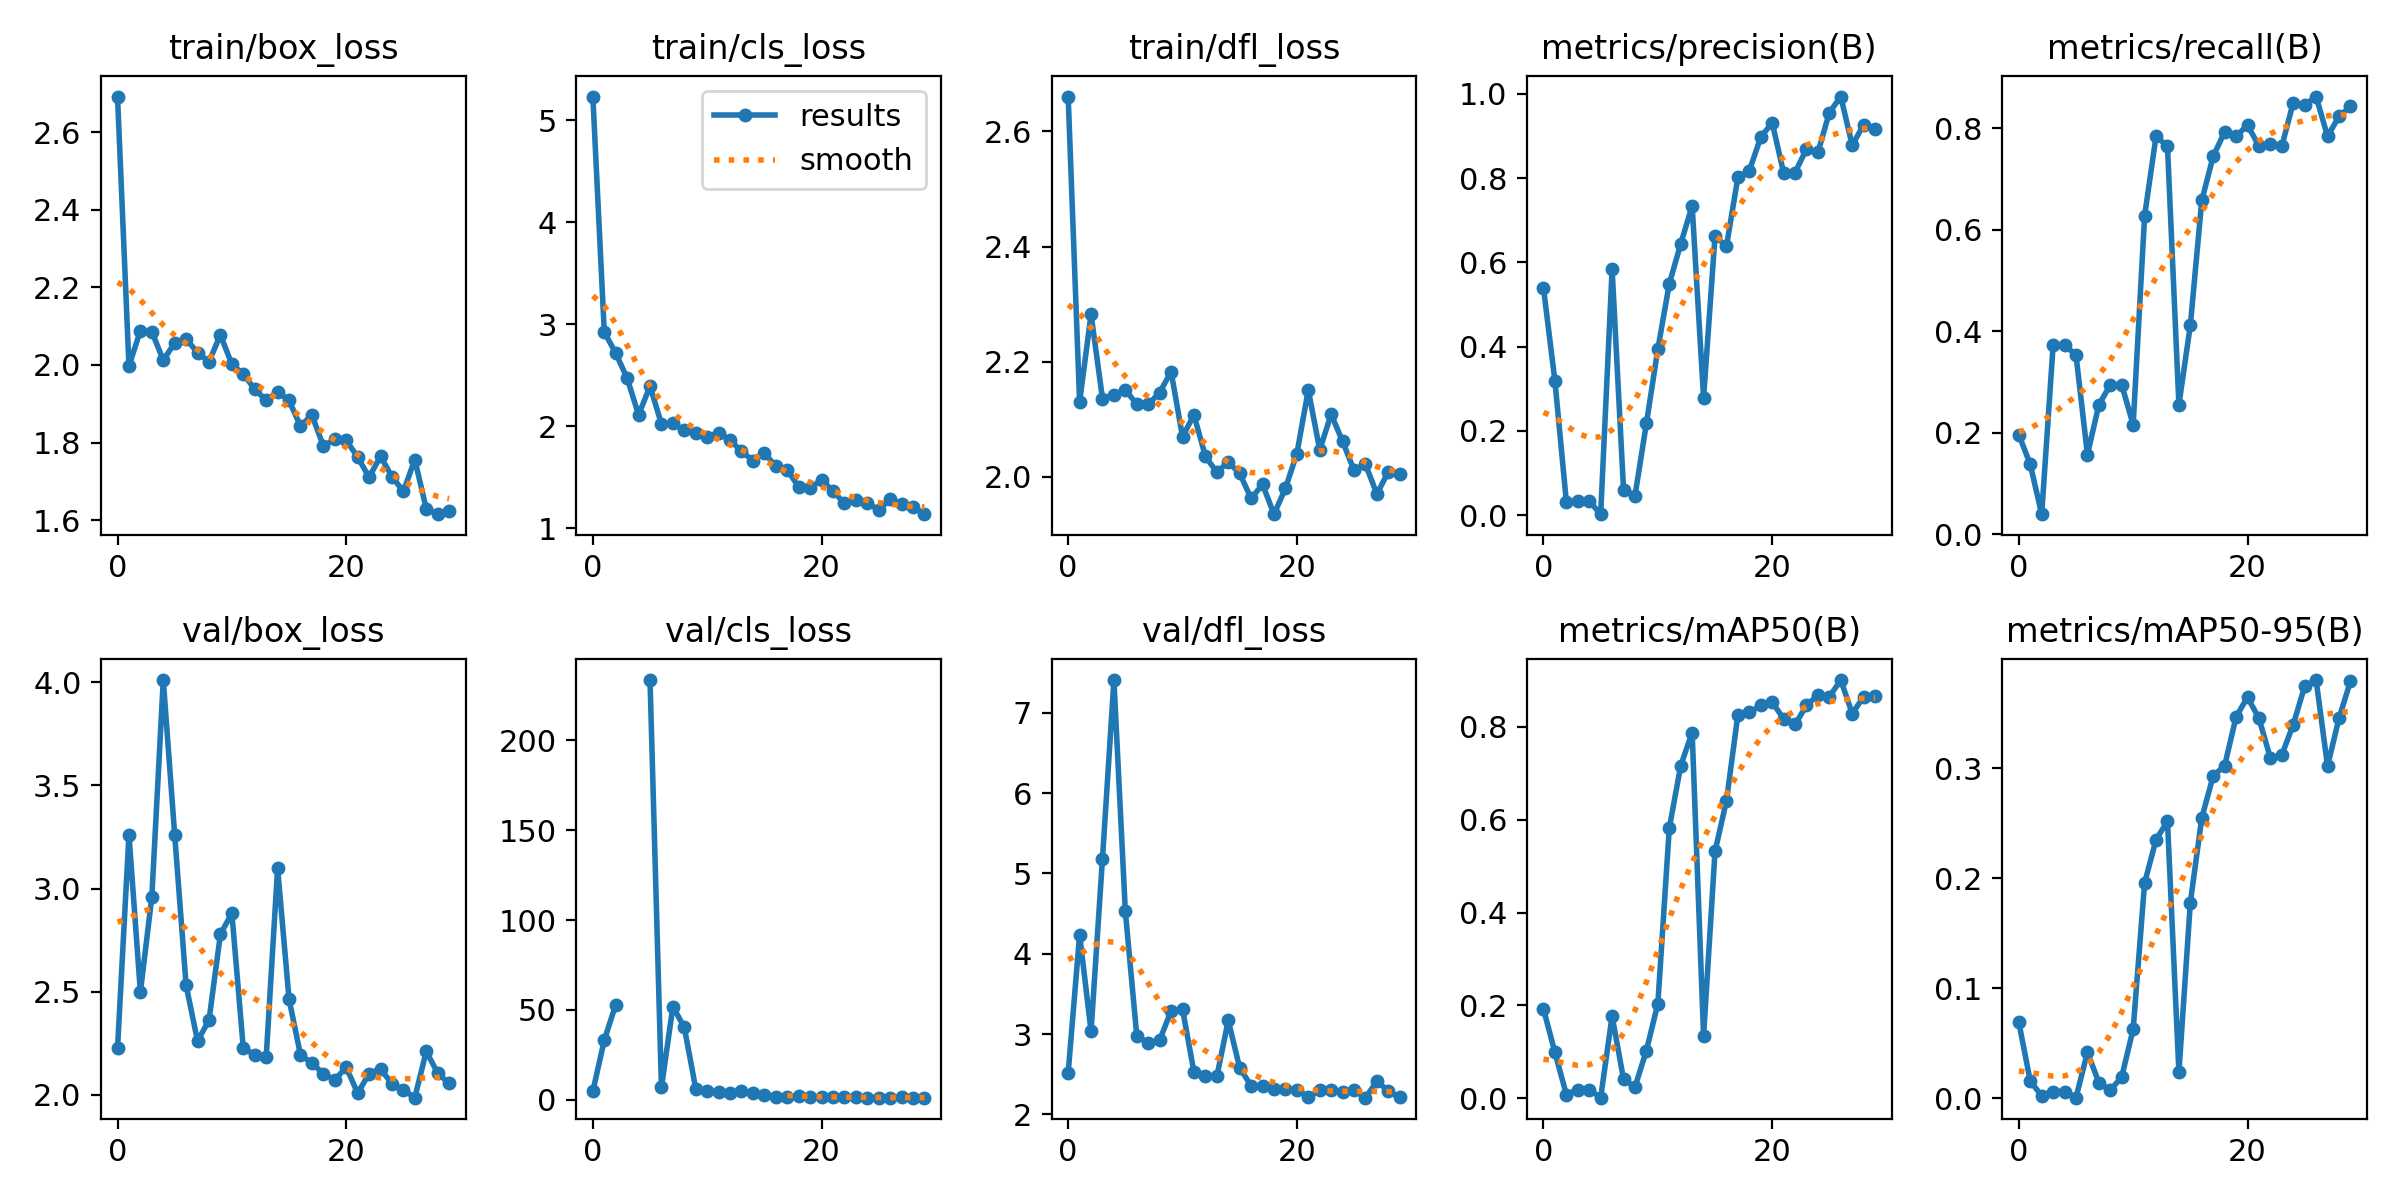

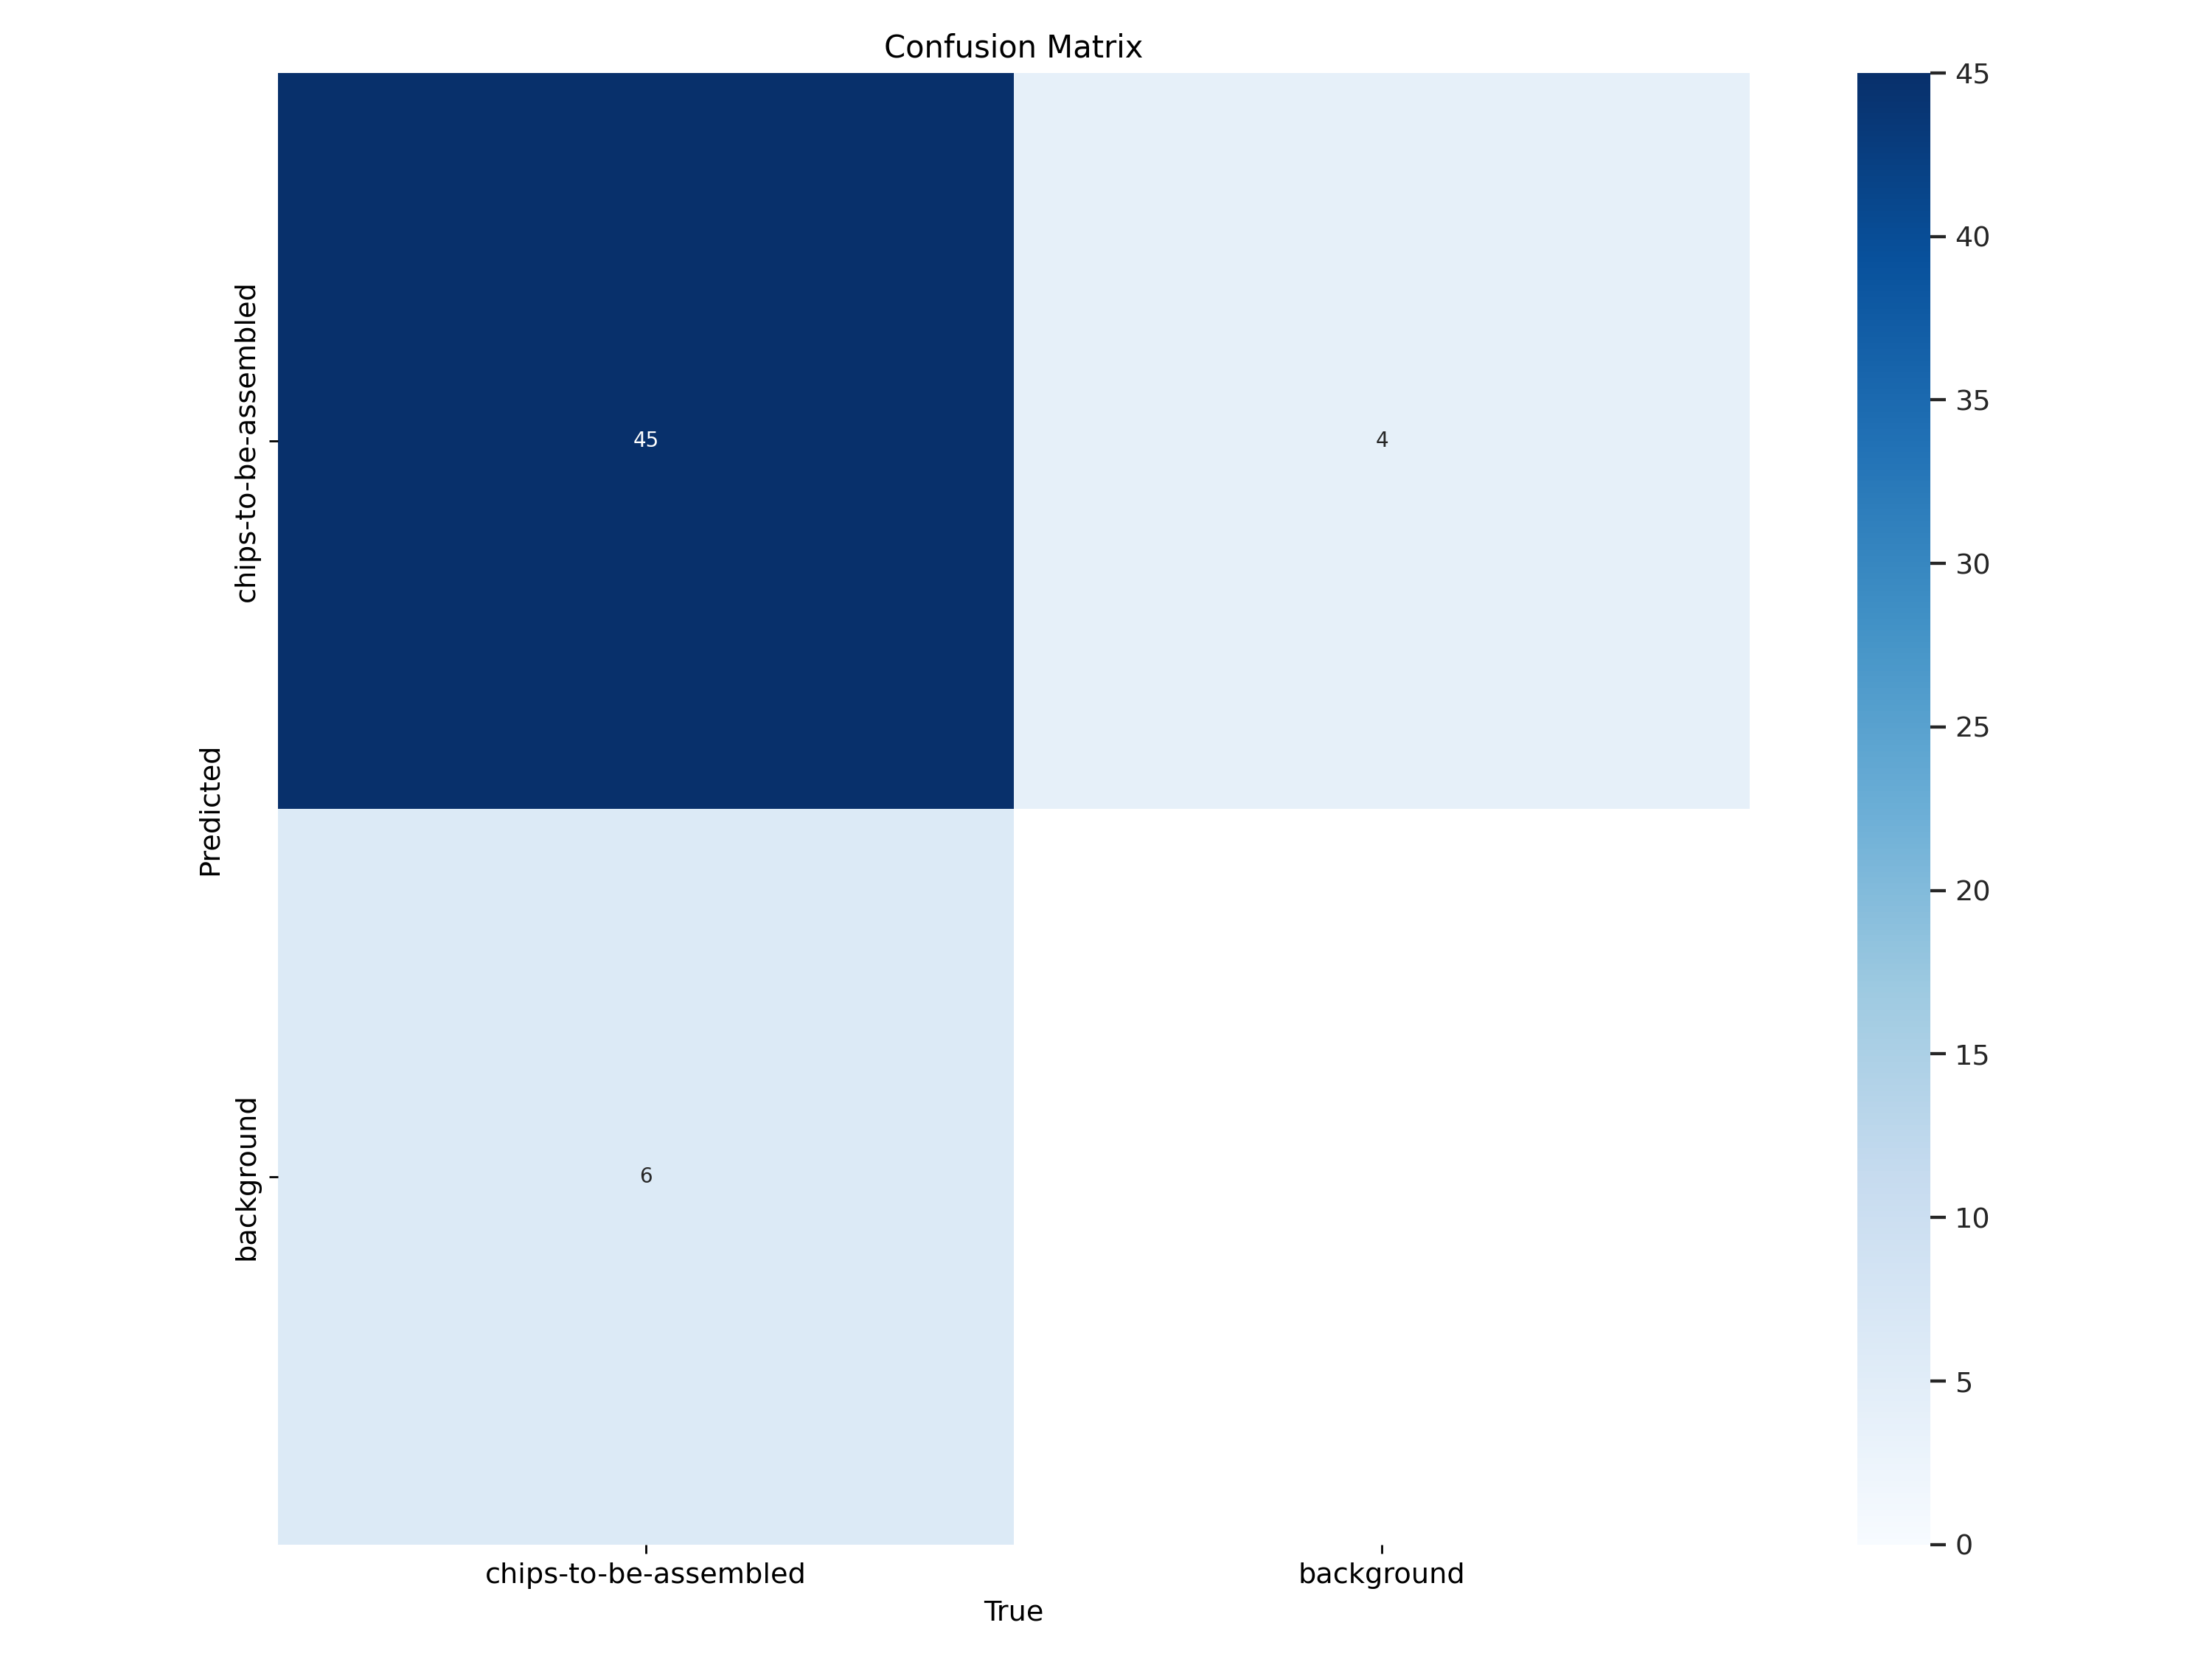

In [10]:
# Display the result summary

from IPython.display import Image, display
%cd {ROOT_DIR}

train_folders = [folder for folder in os.listdir(f'{ROOT_DIR}/runs/detect') if folder.startswith("train")]

# Extract the indices from folder names and find the highest index
# Retraining will output results in new folders with the name format: "train<index>"
indices = [int(folder[len("train"):] if folder[len("train"):] else 0) for folder in train_folders]
highest_index = "" if max(indices) == 0 else max(indices)

results_file_path = f'{ROOT_DIR}/runs/detect/train{highest_index}/results.png'
print(f"Displaying result summary from {results_file_path}")
display(Image(filename=results_file_path, width=2000))

confusion_mat_file_path = f'{ROOT_DIR}/runs/detect/train{highest_index}/confusion_matrix.png'
print(f"Displaying confusion matrix from {confusion_mat_file_path}")
display(Image(filename=confusion_mat_file_path, width=1600))